# Introduction:
For constructing a robust music genre classifier, it is necessary to extract features that allow direct access to the relevant genre-specific information. The feature extraction process is applied to the GTZAN dataset in order to discriminate four music genres: 'Disco', 'Pop', 'Reggae', 'Rock'. Each song
in the database was stored as a 22050 [Hz], 16bits, and mono audio file.

In [0]:
import os
import warnings
import librosa 
import librosa.display
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Importing the Database:
Uploading the dataset to the Colab files in order to process them.





In [2]:
!wget --no-check-certificate -r "https://polimi365-my.sharepoint.com/:u:/g/personal/10580364_polimi_it/EcTX4o6XYNNBnYhVfSVwOtEBfDuajLCG-6ltfnxm3Ej4mQ?download=1" -O "genres.zip" 

will be placed in the single file you specified.

--2020-05-17 16:03:07--  https://polimi365-my.sharepoint.com/:u:/g/personal/10580364_polimi_it/EcTX4o6XYNNBnYhVfSVwOtEBfDuajLCG-6ltfnxm3Ej4mQ?download=1
Resolving polimi365-my.sharepoint.com (polimi365-my.sharepoint.com)... 13.107.136.9
Connecting to polimi365-my.sharepoint.com (polimi365-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/10580364_polimi_it/Documents/genres.zip?&originalPath=aHR0cHM6Ly9wb2xpbWkzNjUtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvMTA1ODAzNjRfcG9saW1pX2l0L0VjVFg0bzZYWU5OQm5ZaFZmU1Z3T3RFQmZEdWFqTENHLTZsdGZueG0zRWo0bVE_cnRpbWU9X3lpNXludjYxMGc [following]
--2020-05-17 16:03:08--  https://polimi365-my.sharepoint.com/personal/10580364_polimi_it/Documents/genres.zip?&originalPath=aHR0cHM6Ly9wb2xpbWkzNjUtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvMTA1ODAzNjRfcG9saW1pX2l0L0VjVFg0bzZYWU5OQm5ZaFZmU1Z3T3RFQmZEdWFqTENHLTZsdGZueG0zRWo0bVE_cnRpbWU9X3lpN

In [3]:
!unzip genres.zip

Archive:  genres.zip
   creating: genres/
   creating: genres/disco/
  inflating: genres/disco/disco.00000.wav  
  inflating: genres/disco/disco.00001.wav  
  inflating: genres/disco/disco.00002.wav  
  inflating: genres/disco/disco.00003.wav  
  inflating: genres/disco/disco.00004.wav  
  inflating: genres/disco/disco.00005.wav  
  inflating: genres/disco/disco.00006.wav  
  inflating: genres/disco/disco.00007.wav  
  inflating: genres/disco/disco.00008.wav  
  inflating: genres/disco/disco.00009.wav  
  inflating: genres/disco/disco.00010.wav  
  inflating: genres/disco/disco.00011.wav  
  inflating: genres/disco/disco.00012.wav  
  inflating: genres/disco/disco.00013.wav  
  inflating: genres/disco/disco.00014.wav  
  inflating: genres/disco/disco.00015.wav  
  inflating: genres/disco/disco.00016.wav  
  inflating: genres/disco/disco.00017.wav  
  inflating: genres/disco/disco.00018.wav  
  inflating: genres/disco/disco.00019.wav  
  inflating: genres/disco/disco.00020.wav  
  infla

# Feature Extraction Process:
Different kind of *low-level* and *high level* audio features are computed. They are categorized into rhythmic, spectral and tonal. They are decomposed into low-level and high-level according to the frame size: low-level features are extracted from a short window (1024 samples, 44.45 [ms] of duration) while high-level features are extracted from longer windows to gain a better frequency resolution (4096 samples, 186 [ms]), the first with 50% of overlap between successive windows, the second with 75%.


1.   **Rhythmic Features**:   

>* Tempo;

2.   **Spectral Features**:

>* Spectral Centroid;
* Spectral Rolloff (85%);
* Spectral Rolloff (95%);
* Spectral Flux;
* RMS Energy;
* Zero-Crossing Rate;
* Spectral Bandwidth;
* Spectral Flatness;
* Spectral Contrast;
* MFCCs;

3. **Tonal Features** (Harmonic):

>* Chromagram;
* Tonal Centroid;
* HCDF (Harmonic Change Detection Function);

The different frame-based features are computed and then integrated over the all audio extract duration by means of the different **statistical moments** like *maximum* value, *minimum* value, *mean*, *standard deviation*, *skewness* and *kurtosis*.
Rhythmic and Tonal features are high-level features and need the longer analysis window to capture their correct behaviour.

In [0]:
def get_features(y, sr):
    # Low-level features Analysis parameters
    n_fft_ll=1024
    hop_length_ll=512

    # High-level features Analysis parameters
    n_fft_hl=4096
    hop_length_hl=1024

    # Low-level features to be computed
    features = {
        'centroid': None,
        'rolloff85': None,
        'rolloff95': None,
        'flux': None,
        'rmse': None,
        'zcr': None,
        'bandwidth': None,
        'flatness': None
    }

    # Computing Spectral Low-level features using Librosa library functions:
    # Spectral Centroid:
    features['centroid'] = librosa.feature.spectral_centroid(y=y,
                                                             sr=sr, 
                                                             n_fft=n_fft_ll, 
                                                             hop_length=hop_length_ll)
    # Spectral Rolloff (85%)
    features['rolloff85'] = librosa.feature.spectral_rolloff(y=y, 
                                                             sr=sr, 
                                                             n_fft=n_fft_ll, 
                                                             hop_length=hop_length_ll, 
                                                             roll_percent=0.85)
    # Spectral Rolloff (95%)
    features['rolloff95'] = librosa.feature.spectral_rolloff(y=y, 
                                                             sr=sr, 
                                                             n_fft=n_fft_ll, 
                                                             hop_length=hop_length_ll, 
                                                             roll_percent=0.95)
    # Spectral Flux
    features['flux'] = librosa.onset.onset_strength(y=y, 
                                                    sr=sr)
    # Root Mean Square Energy
    features['rmse'] = librosa.feature.rms(y=y, 
                                           frame_length=n_fft_ll, 
                                           hop_length=hop_length_ll)
    # Zero-Crossing Rate
    features['zcr'] = librosa.feature.zero_crossing_rate(y=y, 
                                                         frame_length=n_fft_ll, 
                                                         hop_length=hop_length_ll)
    # Spectral Bandwidth
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y=y, 
                                                               sr=sr, 
                                                               n_fft=n_fft_ll, 
                                                               hop_length=hop_length_ll)
    # Spectral Flatness
    features['flatness'] = librosa.feature.spectral_flatness(y=y,
                                                             n_fft=n_fft_ll,
                                                             hop_length=hop_length_ll)
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, 
                                                 sr=sr,
                                                 n_fft=n_fft_ll,
                                                 hop_length=hop_length_ll)
    for idx, v_contrast in enumerate(contrast):
        features['contrast_{}'.format(idx)] = contrast
    
    # Mel-Frequency Cepstral Coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, 
                                n_fft=n_fft_ll,
                                hop_length=hop_length_ll, 
                                n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc
    
    # Computing the Tonal High-Level features using Librosa library functions:
    # Chromagram
    chroma = librosa.feature.chroma_stft(y=y, 
                                         sr=sr, 
                                         n_fft=n_fft_hl,
                                         hop_length=hop_length_hl)
    for idx, v_chroma in enumerate(chroma):
        features['chroma_{}'.format(idx)] = v_chroma

    # Tonal Centroid
    tonal_centroid = librosa.feature.tonnetz(y=librosa.effects.harmonic(y=y), sr=sr)
    for idx, v_tonal in enumerate(tonal_centroid):
        features['tonnetz{}'.format(idx)] = v_tonal

    # Harmonic Changes Detection Function
    features['hcdf'] = librosa.onset.onset_strength(sr=sr, S=tonal_centroid) 
    
    # This inner function extracts the statistical moments from the vectors:
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v, axis=None)
            result['{}_skew'.format(k)] = skew(v, axis=None)
        return result
    
    # Computing the statistical moments for each feature:
    stat_features = get_moments(features)

    # Computing the Rhythmic High-Level features using Librosa library functions:
    stat_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]

    return stat_features

# Loading samples:
 The following function parses the folder structure of the dataset in order to load and compute the features of each audio sample: the 'genres' folder contains a folder for each music genre that needs to be classified. 


In [0]:
def read_process_songs(src_dir):
    # Numerical mapping for each genre label
    genres = {
      'disco': 0,
      'pop': 1,
      'reggae': 2,
      'rock': 3
    }

    # Empty array to store every computed feature vector for each sample
    feature_space = []

    for x, _ in genres.items():
      folder = src_dir + '/' + x
      for root, subdirs, files in os.walk(folder):
        for file in sorted(files):
          # Read the audio files with the Librosa load function
          file_name = folder + '/' + file
          signal, sr = librosa.load(file_name)
          print("Reading file: {}".format(file_name))
          # Extract the features
          features = get_features(signal, sr)
          # Label the feature vector
          features['genre'] = genres[x]
          feature_space.append(features)
    return feature_space

# Features computation:
Extraction of the features for all audio samples and later conversion of the feature_space table object into a `DataFrame` object, which contains a row for each audio entry and a number of columns equal to the total number of features computed; everything is then exported into a .csv file to be used in the Classification step. In the console there is a plotting of a Deprecated use of `np.asscalar(a)` which is caused by the `Librosa` library itself (this is why the filtering of the warnings is used).

In [6]:
warnings.filterwarnings("ignore")
feature_space = read_process_songs('genres');

df_features = pd.DataFrame(feature_space)
df_features.to_csv('features.csv', index=False)

Reading file: genres/disco/disco.00000.wav
Reading file: genres/disco/disco.00001.wav
Reading file: genres/disco/disco.00002.wav
Reading file: genres/disco/disco.00003.wav
Reading file: genres/disco/disco.00004.wav
Reading file: genres/disco/disco.00005.wav
Reading file: genres/disco/disco.00006.wav
Reading file: genres/disco/disco.00007.wav
Reading file: genres/disco/disco.00008.wav
Reading file: genres/disco/disco.00009.wav
Reading file: genres/disco/disco.00010.wav
Reading file: genres/disco/disco.00011.wav
Reading file: genres/disco/disco.00012.wav
Reading file: genres/disco/disco.00013.wav
Reading file: genres/disco/disco.00014.wav
Reading file: genres/disco/disco.00015.wav
Reading file: genres/disco/disco.00016.wav
Reading file: genres/disco/disco.00017.wav
Reading file: genres/disco/disco.00018.wav
Reading file: genres/disco/disco.00019.wav
Reading file: genres/disco/disco.00020.wav
Reading file: genres/disco/disco.00021.wav
Reading file: genres/disco/disco.00022.wav
Reading fil

# Feature Analysis and Class Separability:
Considering a single feature at the time, we want to evaluate its discrimination power among classes. In order to do so, the *Fisher Discriminant Ratio* Definition is applied to each single feature for each possible couple of classes that need to be discriminated.
>$ FDR = \frac{(\mu_i - \mu_j)^2}{\sigma_i^2 + \sigma_j^2}$ 

In [0]:
# Definition of Fisher Discriminant Ratio function
def compute_FDR(genre_idx1, genre_idx2, dimension):
    # Consider all the samples for each specific genre
    samples_genre1 = df_features[100*genre_idx1 : 100*(genre_idx1+1)]
    samples_genre2 = df_features[100*genre_idx2 : 100*(genre_idx2+1)]

    # Compute the centroid and the variance of the given feature dimension
    centroid1 = np.mean(samples_genre1.loc[:, dimension], axis=None)
    centroid2 = np.mean(samples_genre2.loc[:, dimension], axis=None)
    variance1 =  np.var(samples_genre1.loc[:, dimension], axis=None)
    variance2 = np.var(samples_genre2.loc[:, dimension], axis=None)

    # Applying the Definition
    numerator = (centroid1 - centroid2)**2
    denominator = variance1 + variance2
    if denominator != 0 :
        return numerator/denominator
    else :
        return 0
   

The following cell of code computes the FDR for each possible couple of genres and all possible feature dimension.

In [0]:
feature_names = list(feature_space[0].keys())
# Removing the labeling
feature_names.remove('genre')

# Mapping of genres with their numerical identificator
genres = {
      'disco': 0,
      'pop': 1,
      'reggae': 2,
      'rock': 3
      }

# Computing the one-vs-one binary classes from the multiclass problem
genre_combinations = list(itertools.combinations(genres.keys(),2))

# This function extracts from a dictionary the field 'FDR'
def get_value(e):
    return e['FDR']

# The matrix will contain all the FDR values
FDR_matrix = []
# The matrix will contain all the features re-ordered starting from the higher FDR
FDR_feature_matrix = []

for gen1,gen2 in genre_combinations:
    i1 = genres[gen1]
    i2 = genres[gen2]
    row = []
    for feature in feature_names:
        FDR = compute_FDR(i1, i2, feature)
        row.append({'FDR':FDR,'feature':feature})
    row.sort(reverse=True,key=get_value)
    FDR_matrix.append(row)
    FDR_feature_matrix.append([el['feature'] for el in row])

In [10]:
print("Report of the feature discrimination power (FDR) for binary classification problems:\n")
print("disco vs pop:    ", FDR_feature_matrix[0][0:3]) 
print("disco vs reggae: ", FDR_feature_matrix[1][0:3])
print("disco vs rock:   ", FDR_feature_matrix[2][0:3])
print("pop vs reggae:   ", FDR_feature_matrix[3][0:3])
print("pop vs rock:     ", FDR_feature_matrix[4][0:3])
print("reggae vs rock:  ", FDR_feature_matrix[5][0:3])
print("\n")
print("(Only reported the first 3 features in decreasing order of FDR)")

Report of the feature discrimination power (FDR) for binary classification problems:

disco vs pop:     ['mfcc_8_max', 'mfcc_5_min', 'mfcc_8_mean']
disco vs reggae:  ['mfcc_6_std', 'mfcc_4_std', 'mfcc_8_max']
disco vs rock:    ['flux_mean', 'flux_std', 'flux_skew']
pop vs reggae:    ['rolloff95_mean', 'bandwidth_mean', 'mfcc_5_min']
pop vs rock:      ['mfcc_5_min', 'bandwidth_max', 'mfcc_8_max']
reggae vs rock:   ['flux_mean', 'flux_std', 'mfcc_4_std']


(Only reported the first 3 features in decreasing order of FDR)


# Features Visualization:
Through *dimensionality reduction* tecniques it is possible to limit the number of random variables (features) under consideration, obtaining a set of principal variables that can be visualized in a 2-dimensional feature space. The **LDA algorithm** (Linear Discriminant Analysis) can be used for this purpose, because it is able to find out, through a process of optimization of the Fisher Discriminant Ratio, the dimension that accounts for most of the variance between classes, and to project the data along it.

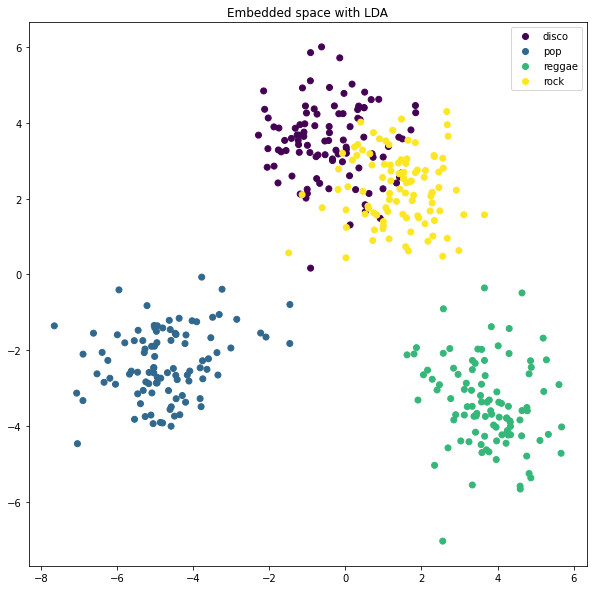

In [12]:
scale = StandardScaler()

X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

x_scaled = scale.fit_transform(X)

lda = LDA(n_components=2)
x_lda = lda.fit_transform(x_scaled, y)

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.legend(handles=scatter.legend_elements()[0], labels=genres)
plt.title("Embedded space with LDA")
plt.show()